In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ipl-2020-player-performance/IPL 2020 Squads.csv
/kaggle/input/ipl-2020-player-performance/sample_submission.csv
/kaggle/input/ipl-2020-player-performance/Matches IPL 2020.csv
/kaggle/input/ipl-2020-player-performance/Matches IPL 2008-2019.csv
/kaggle/input/ipl-2020-player-performance/Training.csv


In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [3]:
train_data = pd.read_csv("../input/ipl-2020-player-performance/Training.csv")

In [4]:
train_data['batting_points'] = train_data['Runs'] + train_data['Boundaries'] + 2 * train_data['Six'] + 8 * train_data['Fifty'] + 16 * train_data['Hundred'] - 2 * train_data['Duck']
train_data['bowling_points'] = 25 * train_data['Wickets'] + 8 * train_data['4W_Haul'] + 16 * train_data['5W_Haul'] + 8 * train_data['Maidens']
train_data['total'] = train_data['batting_points'] + train_data['bowling_points']
train_data

,Id,Runs,Boundaries,Six,Fifty,Hundred,Duck,Batting_Points,Wickets,4W_Haul,5W_Haul,Maidens,Bowling_Points,Total Points,batting_points,bowling_points,total
0,1_Bipul Sharma,0,0,0,0,0,0,0,1,0,0,0,25,25,0,25,25
1,1_DJ Hooda,16,1,1,0,0,0,19,1,0,0,0,25,44,19,25,44
2,1_KM Jadhav,31,5,1,0,0,0,38,0,0,0,0,0,38,38,0,38
3,1_Mandeep Singh,24,5,0,0,0,0,29,0,0,0,0,0,29,29,0,29
4,1_Yuvraj Singh,62,10,3,1,0,0,86,0,0,0,0,0,86,86,0,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15911,11415_RA Jadeja,9,1,0,0,0,0,10,0,0,0,0,0,10,10,0,10
15912,11415_Harbhajan Singh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15913,11415_RG Sharma,15,2,1,0,0,0,19,0,0,0,0,0,19,19,0,19
15914,11415_SN Thakur,2,0,0,0,0,0,2,2,0,0,0,50,52,2,50,52


In [5]:
train_data.isnull().value_counts

<bound method DataFrame.value_counts of           Id   Runs  Boundaries    Six  Fifty  Hundred   Duck  Batting_Points  \
0      False  False       False  False  False    False  False           False   
1      False  False       False  False  False    False  False           False   
2      False  False       False  False  False    False  False           False   
3      False  False       False  False  False    False  False           False   
4      False  False       False  False  False    False  False           False   
...      ...    ...         ...    ...    ...      ...    ...             ...   
15911  False  False       False  False  False    False  False           False   
15912  False  False       False  False  False    False  False           False   
15913  False  False       False  False  False    False  False           False   
15914  False  False       False  False  False    False  False           False   
15915  False  False       False  False  False    False  False        

In [6]:
train_data.shape

(15916, 17)

<AxesSubplot:xlabel='Batting_Points', ylabel='Bowling_Points'>

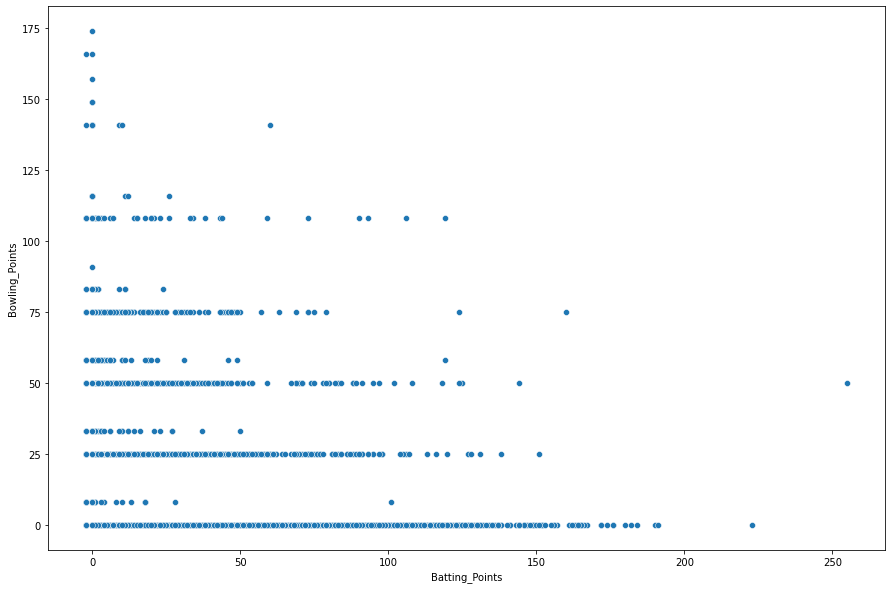

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt 
plt.figure(figsize = (15,10))
sns.scatterplot(x ='Batting_Points', y = 'Bowling_Points', data=train_data)

In [8]:
m20 = pd.read_csv("../input/ipl-2020-player-performance/Matches IPL 2020.csv")
m20 = m20[['match_id', 'city', 'date']]
m20.head()

,match_id,city,date
0,1216492,Abu Dhabi,9/19/2020
1,1216493,Dubai (DSC),9/20/2020
2,1216534,Dubai (DSC),9/21/2020
3,1216496,Sharjah,9/22/2020
4,1216508,Abu Dhabi,9/23/2020


In [9]:
m0819 = pd.read_csv("../input/ipl-2020-player-performance/Matches IPL 2008-2019.csv")
m0819 = m0819[['match_id', 'city', 'date']]
m0819.head()

,match_id,city,date
0,60,Bangalore,18-04-2008
1,61,Chandigarh,19-04-2008
2,62,Delhi,19-04-2008
3,63,Mumbai,20-04-2008
4,64,Kolkata,20-04-2008


In [10]:
matches = pd.merge(m0819, m20, on = 'match_id', how = 'outer' )
matches

,match_id,city_x,date_x,city_y,date_y
0,60,Bangalore,18-04-2008,NaN,NaN
1,61,Chandigarh,19-04-2008,NaN,NaN
2,62,Delhi,19-04-2008,NaN,NaN
3,63,Mumbai,20-04-2008,NaN,NaN
4,64,Kolkata,20-04-2008,NaN,NaN
...,...,...,...,...,...
811,1216495,NaN,NaN,Sharjah,11/3/2020
812,1237177,NaN,NaN,Dubai (DSC),11/5/2020
813,1237178,NaN,NaN,Abu Dhabi,11/6/2020
814,1237180,NaN,NaN,Abu Dhabi,11/8/2020


In [11]:
train_data[['match_id','Player_name']] = train_data['Id'].str.split('_',expand = True) 
train_data['match_id'] = train_data['match_id'].astype(int)
train_data = pd.merge(train_data, matches, on = 'match_id', how = 'inner')
train_data

,Id,Runs,Boundaries,Six,Fifty,Hundred,Duck,Batting_Points,Wickets,4W_Haul,...,Total Points,batting_points,bowling_points,total,match_id,Player_name,city_x,date_x,city_y,date_y
0,1_Bipul Sharma,0,0,0,0,0,0,0,1,0,...,25,0,25,25,1,Bipul Sharma,Hyderabad,5/4/2017,NaN,NaN
1,1_DJ Hooda,16,1,1,0,0,0,19,1,0,...,44,19,25,44,1,DJ Hooda,Hyderabad,5/4/2017,NaN,NaN
2,1_KM Jadhav,31,5,1,0,0,0,38,0,0,...,38,38,0,38,1,KM Jadhav,Hyderabad,5/4/2017,NaN,NaN
3,1_Mandeep Singh,24,5,0,0,0,0,29,0,0,...,29,29,0,29,1,Mandeep Singh,Hyderabad,5/4/2017,NaN,NaN
4,1_Yuvraj Singh,62,10,3,1,0,0,86,0,0,...,86,86,0,86,1,Yuvraj Singh,Hyderabad,5/4/2017,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15911,11415_RA Jadeja,9,1,0,0,0,0,10,0,0,...,10,10,0,10,11415,RA Jadeja,Hyderabad,12/5/2019,NaN,NaN
15912,11415_Harbhajan Singh,0,0,0,0,0,0,0,0,0,...,0,0,0,0,11415,Harbhajan Singh,Hyderabad,12/5/2019,NaN,NaN
15913,11415_RG Sharma,15,2,1,0,0,0,19,0,0,...,19,19,0,19,11415,RG Sharma,Hyderabad,12/5/2019,NaN,NaN
15914,11415_SN Thakur,2,0,0,0,0,0,2,2,0,...,52,2,50,52,11415,SN Thakur,Hyderabad,12/5/2019,NaN,NaN


In [12]:
d1 = train_data[(train_data['Player_name'] == 'Bipul Sharma')]
d1

,Id,Runs,Boundaries,Six,Fifty,Hundred,Duck,Batting_Points,Wickets,4W_Haul,...,Total Points,batting_points,bowling_points,total,match_id,Player_name,city_x,date_x,city_y,date_y
0,1_Bipul Sharma,0,0,0,0,0,0,0,1,0,...,25,0,25,25,1,Bipul Sharma,Hyderabad,5/4/2017,NaN,NaN
106,6_Bipul Sharma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,Bipul Sharma,Hyderabad,9/4/2017,NaN,NaN
272,14_Bipul Sharma,21,3,1,0,0,0,26,0,0,...,26,26,0,26,14,Bipul Sharma,Kolkata,15-04-2017,NaN,NaN
507,25_Bipul Sharma,0,0,0,0,0,0,0,1,0,...,25,0,25,25,25,Bipul Sharma,Pune,22-04-2017,NaN,NaN
740,36_Bipul Sharma,0,0,0,0,0,0,0,0,0,...,0,0,0,0,36,Bipul Sharma,Hyderabad,30-04-2017,NaN,NaN
890,43_Bipul Sharma,8,0,0,0,0,0,8,1,0,...,33,8,25,33,43,Bipul Sharma,Hyderabad,6/5/2017,NaN,NaN
1186,57_Bipul Sharma,2,0,0,0,0,0,2,0,0,...,2,2,0,2,57,Bipul Sharma,Bangalore,17-05-2017,NaN,NaN
3769,181_Bipul Sharma,0,0,0,0,0,0,0,1,0,...,25,0,25,25,181,Bipul Sharma,Bangalore,16-03-2010,NaN,NaN
3868,186_Bipul Sharma,8,1,0,0,0,0,9,1,0,...,34,9,25,34,186,Bipul Sharma,Cuttack,19-03-2010,NaN,NaN
4274,205_Bipul Sharma,0,0,0,0,0,0,0,1,0,...,25,0,25,25,205,Bipul Sharma,Chandigarh,2/4/2010,NaN,NaN


In [13]:
train_data.shape

(15916, 23)

The **train_data** now contain players who played in IPL 2020 only!!!!

**Predicted Value**

In [14]:
d2 = train_data.groupby(['match_id','Player_name'])['total'].sum().reset_index()
d2

,match_id,Player_name,total
0,1,A Choudhary,34
1,1,A Nehra,50
2,1,B Kumar,50
3,1,BCJ Cutting,22
4,1,Bipul Sharma,25
...,...,...,...
15911,11415,RG Sharma,19
15912,11415,SK Raina,9
15913,11415,SL Malinga,25
15914,11415,SN Thakur,52


In [15]:
d2 = d2[(d2['Player_name'] == 'Bipul Sharma')]
d2

,match_id,Player_name,total
4,1,Bipul Sharma,25
111,6,Bipul Sharma,0
275,14,Bipul Sharma,26
510,25,Bipul Sharma,25
741,36,Bipul Sharma,0
894,43,Bipul Sharma,33
1187,57,Bipul Sharma,2
3770,181,Bipul Sharma,25
3872,186,Bipul Sharma,34
4276,205,Bipul Sharma,25


In [16]:
pi_p = train_data[['Player_name','match_id','total']]
pi_p = pi_p.groupby(['Player_name','match_id']).sum().reset_index()
pi_p

,Player_name,match_id,total
0,A Ashish Reddy,331,0
1,A Ashish Reddy,341,50
2,A Ashish Reddy,346,38
3,A Ashish Reddy,348,25
4,A Ashish Reddy,352,28
...,...,...,...
15911,Z Khan,612,25
15912,Z Khan,623,27
15913,Z Khan,625,0
15914,Z Khan,628,0


In [17]:
pi_p[pi_p['Player_name'] == 'TA Boult'].head()

,Player_name,match_id,total
14387,TA Boult,3,25
14388,TA Boult,7,0
14389,TA Boult,11,0
14390,TA Boult,14,25
14391,TA Boult,53,55


In [18]:
pi_l = train_data[['match_id','Player_name','Total Points']]
pi_l = pi_l.groupby(['match_id','Player_name']).sum().reset_index()
pi_l

,match_id,Player_name,Total Points
0,1,A Choudhary,34
1,1,A Nehra,50
2,1,B Kumar,50
3,1,BCJ Cutting,22
4,1,Bipul Sharma,25
...,...,...,...
15911,11415,RG Sharma,19
15912,11415,SK Raina,9
15913,11415,SL Malinga,25
15914,11415,SN Thakur,52


In [19]:
#calculate RMSE
rmse = sqrt(mean_squared_error(pi_l['Total Points'], pi_p['total'] )) 

In [20]:
rmse

42.85906522813118

In [21]:
train_data1= pd.read_csv("../input/ipl-2020-player-performance/Training.csv")

In [22]:

x = np.array(train_data1.iloc[:,1:-1])
y = np.array(train_data1.iloc[:,-1])

In [23]:
x

array([[ 0,  0,  0, ...,  0,  0, 25],
       [16,  1,  1, ...,  0,  0, 25],
       [31,  5,  1, ...,  0,  0,  0],
       ...,
       [15,  2,  1, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  0, 50],
       [16,  2,  1, ...,  0,  0,  0]])

In [24]:

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,random_state=0)
sc = StandardScaler()
sc.fit(train_x)
train_x = sc.transform(train_x)
test_x = sc.transform(test_x)

In [25]:

lr = LinearRegression()
lr.fit(train_x,train_y)

LinearRegression()

**Root Mean Square **

In [26]:
y_pred = lr.predict(test_x)
rmse = np.sqrt(mean_squared_error(y_pred,test_y))
rmse

2.154633710686263e-14

In [27]:
y_pred = np.round(y_pred)
y_pred

array([50., 14.,  5., ..., 48., 21., -0.])

In [28]:
sample = pd.read_csv("../input/ipl-2020-player-performance/sample_submission.csv")
sample[['match_id', 'Player_name']] = sample['Id'].str.split("_", expand = True)
sample

,Id,Total Points,match_id,Player_name
0,1216492_AS Yadav,0,1216492,AS Yadav
1,1216492_AT Rayudu,0,1216492,AT Rayudu
2,1216492_DL Chahar,0,1216492,DL Chahar
3,1216492_F du Plessis,0,1216492,F du Plessis
4,1216492_HH Pandya,0,1216492,HH Pandya
...,...,...,...,...
1278,1237181_S Hetmyer,0,1237181,S Hetmyer
1279,1237181_SA Yadav,0,1237181,SA Yadav
1280,1237181_SS Iyer,0,1237181,SS Iyer
1281,1237181_SS Tiwary,0,1237181,SS Tiwary


In [29]:
sample['Player_name'].isnull().values.sum()

0

In [30]:
players = sample['Player_name'].unique().tolist()
df2 = pi_p[pi_p['Player_name'].isin(players)]
df2


,Player_name,match_id,total
106,A Mishra,5,8
107,A Mishra,9,75
108,A Mishra,15,25
109,A Mishra,18,25
110,A Mishra,21,0
...,...,...,...
15668,YS Chahal,11330,25
15669,YS Chahal,11333,0
15670,YS Chahal,11337,50
15671,YS Chahal,11340,25


In [31]:
df = pd.DataFrame()
df['match_id'] = sample['match_id']
df['Player_name'] = sample['Player_name']
df['Total Points'] = pi_l["Total Points"]
df['Id'] = df['match_id']+'_'+df['Player_name']
df

,match_id,Player_name,Total Points,Id
0,1216492,AS Yadav,34,1216492_AS Yadav
1,1216492,AT Rayudu,50,1216492_AT Rayudu
2,1216492,DL Chahar,50,1216492_DL Chahar
3,1216492,F du Plessis,22,1216492_F du Plessis
4,1216492,HH Pandya,25,1216492_HH Pandya
...,...,...,...,...
1278,1237181,S Hetmyer,25,1237181_S Hetmyer
1279,1237181,SA Yadav,167,1237181_SA Yadav
1280,1237181,SS Iyer,32,1237181_SS Iyer
1281,1237181,SS Tiwary,2,1237181_SS Tiwary


In [32]:
df.isnull().values.sum()

0

In [33]:
dt=pd.DataFrame()
dt['Id'] = df['Id']
dt['Total Points'] = df['Total Points'] 
dt

,Id,Total Points
0,1216492_AS Yadav,34
1,1216492_AT Rayudu,50
2,1216492_DL Chahar,50
3,1216492_F du Plessis,22
4,1216492_HH Pandya,25
...,...,...
1278,1237181_S Hetmyer,25
1279,1237181_SA Yadav,167
1280,1237181_SS Iyer,32
1281,1237181_SS Tiwary,2


In [34]:
#print(dt[(dt['Id' ]== '1216519_AM Rahane')])


In [35]:
dt.to_csv('score.csv', index=False)